# Average density profiles with no ELMs

Plot time-averaged ELM-free density profiles.

Remove the time instants corresponding to ELMs (according to the "ELM" shotfile) and compute the average and standard deviation on a given time window.

## Removing ELMs

We remove the time instants with ELMs using the _ELM_ shotfile. To better filter out the ELMs, you need to specify a rejection window arround the ELM peak. For example, you can reject one millisecond before the peak `preft = 1` and two milliseconds after the peak `suft=2`. To verify that the ELM rejection routine is working properly, we can test it on an arbitrary diagnostic, e.g., `MAC/Ipolsoli` or `POT/EMLa-Han`.

#### Import libraries

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump#### Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipfnpytools.ddremoveELMData import ddremoveELMData 
import reflectometry as rfl
from ipfnpytools.trz_to_rhop import trz_to_rhop

### <span style="color:blue">Parameters</span>

In [79]:
# Shot number
shot = 35835

# Choose edition for reflectometry (0 for most recent)
edition = 0

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# Path to dump file 
path = None

# Signal to overlay the density profiles
support_signal = ('DCN', 'H-0')

# Choose edition for the supporting signal (0 for most recent)
support_signal_edition = 0

# Magnetic equillibrium
equillibrium = "EQH"

# Number of density profiles to show in the plots
number_of_profiles = 2

# Size of window to average profiles [ms]
time_window = 10

# Show error bars corresponding to the standard deviation of the average profile
show_std = True

# Show HFS and LFS rho profiles in the same window
show_same = True

# Show wall
show_wall = False

# Time to reject before each ELM peak [ms]
preft = 1

# Time to reject after each ELM peak [ms]
suft = 6

# Select diagnostic for testing ELM rejection ("Shotfile", "Signal")
diag = ("MAC", "Ipolsoli")

# HFS cutoff density (1e19 m^-3)
hfs_cut = 3.0

### Load support signal from AFS

<IPython.core.display.Javascript object>


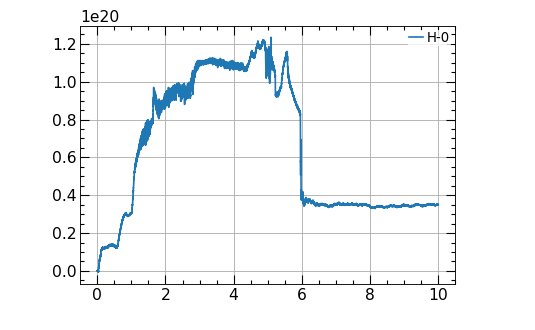

(<Figure size 535.433x330.916 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b15d55f3890>)

In [80]:
signal = getsig(shot, support_signal[0], support_signal[1], edition=support_signal_edition)
plots(signal.time, signal.data, labels=signal.name)

### Load test signal and compute ELM mask

In [81]:
# Get ELM mask from the ELM shotfile
test_signal = getsig(shot, diag[0], diag[1])
elmmsk = ddremoveELMData(shot, test_signal.time, preft=preft*1e-3, suft=suft*1e-3)

### Plot ELM rejection test

<IPython.core.display.Javascript object>


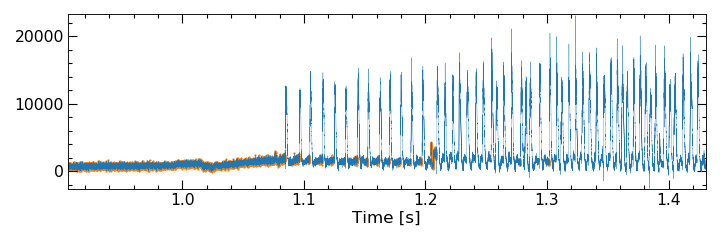

In [82]:
plt.figure(figsize=(9, 3))
plt.plot(test_signal.time, test_signal.data, lw=0.3)
plt.scatter(test_signal.time[elmmsk], test_signal.data[elmmsk], color='C1', marker='o', s=1)
plt.grid()
plt.xlabel("Time [s]")
plt.tight_layout()
# plt.xlim(2.2, 6.3)
# plt.ylim(-4e4, 4e4)

### Fetch density profile data

In [83]:
time, lfs_signal, hfs_signal, lfs_area, hfs_area = rfl.fetch(shot, path if source=='dump' else None, verbose=False)

# Remove NaN's
lfs_area = np.nan_to_num(lfs_area)
hfs_area = np.nan_to_num(hfs_area)

lfs_signal*=1e-19
hfs_signal*=1e-19

# Cutoff HFS density
idx = hfs_signal[0] < hfs_cut
hfs_signal = hfs_signal[:, idx]
hfs_area = hfs_area[:, idx]

### Compute ELM mask for the density profiles

In [84]:
mask = ddremoveELMData(shot, time, preft=preft*1e-3, suft=suft*1e-3)

### Apply mask and compute average and standard deviation

In [85]:
time_masked = time[mask]

N = int(time_window*1e-3/(time[1] - time[0]))
print("Averaging %d profiles on a %.3lf ms window." % (N, time_window))

# # Apply the ELM removal mask
lfs_area_masked = lfs_area[mask]
hfs_area_masked = hfs_area[mask]

lfs_average = pd.DataFrame(lfs_area_masked).rolling(window=N, center=True).mean().values
hfs_average = pd.DataFrame(hfs_area_masked).rolling(window=N, center=True).mean().values

lfs_std = pd.DataFrame(lfs_area_masked).rolling(window=N, center=True).std().values
hfs_std = pd.DataFrame(hfs_area_masked).rolling(window=N, center=True).std().values

Averaging 71 profiles on a 10.000 ms window.


### Plot density vs. R \[m\]

<IPython.core.display.Javascript object>


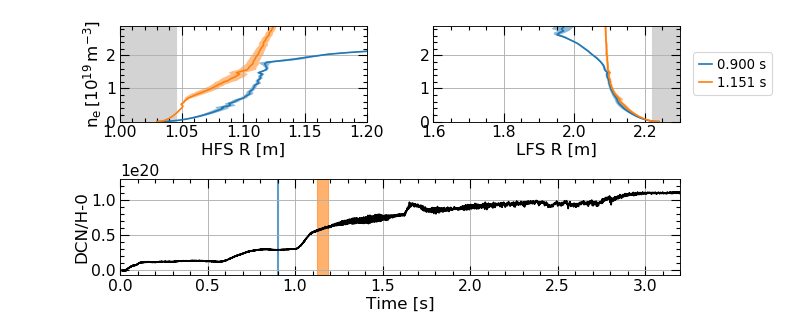

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIuODc2ODM3NzMwNDA3NzE1LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [86]:
fig1, ax1, ax2, ax3 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time_masked, y2=hfs_average, y3=lfs_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=hfs_std if show_std else None, 
    ey3=lfs_std if show_std else None, 
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2="HFS R [m]", lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3="LFS R [m]", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=None, m3=None, 
    strip_pts=N, 
    show_same=False,
    paint_rho=False, paint_wall=True,
    sharex=False, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the figure manualy with your cursor, or by running the following cell

In [87]:
fig1.set_size_inches(10, 4)  # Figure size in inches (widht, height)

ax1.set_xlim(0, 3.2)  # Bottom plot x-range
# ax1.set_ylim(-0.03, 0.06)  # Bottom plot y-range

ax2.set_xlim(1, 1.2)  # Top-left plot x-range
ax2.set_ylim(0, 2.9)  # Top-left plot y-range

ax3.set_xlim(1.6, 2.3) # Top-right plot x-range
ax3.set_ylim(0, 2.9)  # Top-right plot y-range

(0, 2.9)

### Save the figure to your working directory

In [88]:
fig_name = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d/%d_average_no_ELM_profiles_R" % (shot, shot)
save_figure(fig1, fig_name)

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/35835/35835_average_no_ELM_profiles_R.png


### Convert R \[m\] to $\rho$ and compute the average and std.

In [89]:
# Set the antenna Z
zl = 0.14
zh = 0.07

# Walls
inner_wall = 1.045
outer_wall = 2.22

inner_wall_rho = trz_to_rhop(time_masked, inner_wall, zh, shot, eq=equillibrium)
outer_wall_rho = trz_to_rhop(time_masked, outer_wall, zl, shot, eq=equillibrium)

rhol = trz_to_rhop(time_masked, lfs_area_masked, np.ones_like(lfs_area_masked)*zl, shot, eq=equillibrium)
rhoh = trz_to_rhop(time_masked, hfs_area_masked, np.ones_like(hfs_area_masked)*zh, shot, eq=equillibrium)

rhol = np.nan_to_num(rhol)
rhoh = np.nan_to_num(rhoh)

# Compute the average and std in rho ------------------------

rhol_average = pd.DataFrame(rhol).rolling(window=N, center=True).mean().values
rhoh_average = pd.DataFrame(rhoh).rolling(window=N, center=True).mean().values

rhol_std = pd.DataFrame(rhol).rolling(window=N, center=True).std().values
rhoh_std = pd.DataFrame(rhoh).rolling(window=N, center=True).std().values

trz_to_rhop:36514/36514
trz_to_rhop:36514/36514
trz_to_rhop:36514/36514
trz_to_rhop:36514/36514


### Plot density vs. $\rho$

<IPython.core.display.Javascript object>


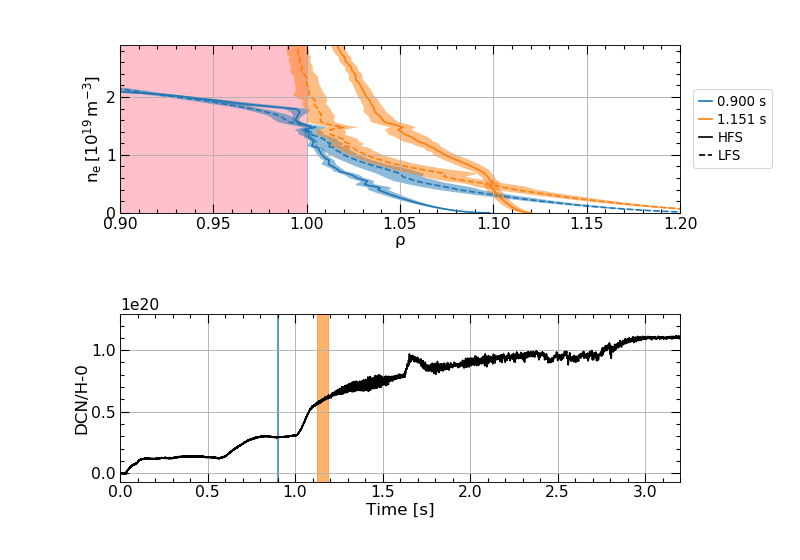

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTIuODc2ODM3NzMwNDA3NzE1LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTEwLjAsIHJlYWRvdXRfZm9ybWF0PXXigKY=


In [90]:
fig2, ax4, ax5, ax6 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time_masked, y2=rhoh_average, y3=rhol_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=rhoh_std if show_std else None, 
    ey3=rhol_std if show_std else None, 
    lx1="Time [s]", ly1=support_signal[0] + '/' + support_signal[1],
    ly2=r"$\rho$" if show_same else r"HFS $\rho$", 
    lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3=r"LFS $\rho$", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=inner_wall_rho if show_wall else None, ### Plot density vs. $\rho$
    m3=outer_wall_rho if show_wall else None, 
    strip_pts=N, show_same=show_same, 
    paint_rho=True, paint_wall=False,
    sharex=True, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the above figure manualy with your cursor, or by running the following cell

In [91]:
fig2.set_size_inches(10, 7)  # Figure size in inches (width, height)

ax4.set_xlim(0, 3.2)  # Bottom plot x-range
# ax4.set_ylim(None, None)  # Bottom plot y-range

ax5.set_xlim(0.9, 1.2)  # Top-left plot x-range
ax5.set_ylim(0, 2.9)  # Top-left plot y-range

ax6.set_xlim(0.9, 1.2) # Top-right plot x-range
ax6.set_ylim(0, 2.9)  # Top-right plot y-range

(0, 2.9)

### Save the figure to your working directory

In [92]:
fig_name = "/afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/%d/%d_average_no_ELM_profiles_rho" % (shot, shot)
save_figure(fig2, fig_name)

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/35835/35835_average_no_ELM_profiles_rho.png
